# Directory Analyzer
This notebook provides a solution to analyze the content of a directory, focusing on two main aspects:
1. File Format Distribution: Visualizing the distribution of different file formats (such as .pdf, .txt, etc.) in the directory.
2. Repeated File Names: Identifying and listing file names that appear multiple times, regardless of their file extensions.

## Key Features:
- Directory Exploration: Recursively explores all subdirectories and files.
- File Format Analysis: Counts and visualizes the occurrence of different file formats.
- Repeated File Name Detection: Finds and displays repeated file names (ignoring extensions).

This analysis is useful for understanding the structure of large directories and identifying potential duplicates in file names.

In [1]:
import os
import shutil
import time
import matplotlib.pyplot as plt
from collections import defaultdict
import comtypes.client

# Functions
### Function to Analyze the Directory

In [2]:
# Function to count file formats and repeated file names
def analyze_directory(directory):
    formats_count = defaultdict(int)  
    names_count = defaultdict(list)   

    # Recursive function to explore directories
    def explore_directory(path):
        for item in os.listdir(path):
            full_path = os.path.join(path, item)
            if os.path.isdir(full_path):
                explore_directory(full_path)  
            else:
                # Count formats
                ext = os.path.splitext(item)[1].lower()  
                formats_count[ext] += 1  

                # Count names without extension
                name_without_ext = os.path.splitext(item)[0]  
                names_count[name_without_ext].append(item)    

    explore_directory(directory)
    return formats_count, names_count

### Function to Plot File Formats

In [3]:
# Function to visualize file formats data
def plot_file_formats(formats_count):
    formats = list(formats_count.keys())
    counts = list(formats_count.values())

    plt.figure(figsize=(10, 6))
    bars = plt.barh(formats, counts, color='skyblue')

    # Add labels on each bar to show the exact number of files
    for bar, count in zip(bars, counts):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                str(count), va='center', ha='left', fontsize=10)

    plt.xlabel('Number of Files')
    plt.ylabel('File Formats')
    plt.title('Distribution of File Formats in Directory')
    plt.tight_layout()
    plt.show()

### Function to Display Repeated File Names

In [4]:
# Function to display repeated file names in a readable format
def show_repeated_names(names_count):
    repeated_files = {name: files for name, files in names_count.items() if len(files) > 1}
    if repeated_files:
        print("Repeated file names (without extensions):")
        for idx, (name, files) in enumerate(repeated_files.items(), start=1):
            print(f"\n{idx}. {name}:")
            for file in files:
                print(f"   - {file}")
    else:
        print("No repeated file names found.")

### Function to Delete not supported files

In [5]:
# Function to delete all files that don't have correct format in a directory and its subdirectories
def clean_files(directory):
    allowed_formats = {".txt", ".doc", ".docx", ".pptx", ".pdf"}
    files_deleted = 0

    # Walk through all files and subdirectories in the given directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            ext = os.path.splitext(file)[1].lower() 
            if ext not in allowed_formats:
                file_path = os.path.join(root, file)
                try:
                    os.remove(file_path)
                    print(f"Deleted: {file_path}")
                    files_deleted += 1
                except Exception as e:
                    print(f"Error deleting {file_path}: {e}")
    
    print(f"\nTotal files deleted: {files_deleted}")

### Function to convert Word documents (.doc) to PDF

In [6]:
# Function to move files from one directory to another
def convert_doc_to_pdf(doc_path, pdf_path):
    word = comtypes.client.CreateObject('Word.Application')
    word.Visible = False
    
    # Normalize paths to avoid issues with slashes
    doc_path = os.path.normpath(doc_path)
    pdf_path = os.path.normpath(pdf_path)

    try:
        doc = word.Documents.Open(doc_path)
        # 17 is the file format code for PDF in Word
        doc.SaveAs(pdf_path, FileFormat=17)
        doc.Close()
        print(f"Converted: {doc_path} to {pdf_path}")

        # Remove the original .doc file
        os.remove(doc_path)
        print(f"Deleted: {doc_path}")

    except Exception as e:
        print(f"Failed to convert {doc_path}: {e}")
    finally:
        word.Quit()

def parse_doc_to_pdf(directory):
    if not os.path.exists(directory):
        print(f"The directory {directory} does not exist.")
        return

    # Traverse the directory and subdirectories
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.doc') and not file.lower().endswith('.docx'):
                doc_path = os.path.join(root, file)
                pdf_file = file.rsplit('.', 1)[0] + '.pdf'
                pdf_path = os.path.join(root, pdf_file)

                convert_doc_to_pdf(doc_path, pdf_path)

### Function to Delete duplicated files

In [7]:
# Function to delete duplicate files in a directory and its subdirectories
def delete_duplicate_files(directory):
    files_dict = {}
    deleted_docx_count = 0
    deleted_pdf_count = 0

    start_time = time.time()

    # Traverse the directory and subdirectories
    for root, dirs, files in os.walk(directory):
        for file in files:
            filename_without_extension, extension = os.path.splitext(file)
            filename_without_extension = filename_without_extension.lower()
            full_path = os.path.join(root, file)

            if filename_without_extension in files_dict:
                files_dict[filename_without_extension].append(full_path)
            else:
                files_dict[filename_without_extension] = [full_path]

    files_to_delete = []

    for name, paths in files_dict.items():
        if len(paths) > 1:
            # If there are duplicates, determine which to delete
            for path in paths:
                if path.lower().endswith('.pdf'):
                    deleted_pdf_count += 1
                else:
                    files_to_delete.append(path)
                    deleted_docx_count += 1

            # If both are PDFs, choose one to delete
            if len(paths) == 2 and all(path.lower().endswith('.pdf') for path in paths):
                files_to_delete.append(paths[1])

    # Delete the files that are not PDFs
    for file in files_to_delete:
        try:
            os.remove(file)
            print(f"Deleted: {file}")
        except Exception as e:
            print(f"Could not delete {file}: {e}")

    end_time = time.time()
    execution_time = end_time - start_time

    print(f"Total files deleted: {deleted_docx_count + deleted_pdf_count}")
    print(f"DOCX files deleted: {deleted_docx_count}")
    print(f"PDF files deleted: {deleted_pdf_count}")
    print(f"Execution time: {execution_time:.2f} seconds")

### Function to Move all files in root directory

In [8]:
# Function to move all files in subdirectories to the root directory and remove empty subdirectories
def move_files_and_clean_empty_dirs(directory):
    if not os.path.exists(directory):
        print(f"The directory {directory} does not exist.")
        return

    for root, dirs, files in os.walk(directory):
        for file in files:
            # Get the full path of the file
            source_file_path = os.path.join(root, file)

            # Move the file to the root directory
            shutil.move(source_file_path, os.path.join(directory, file))
            print(f"Moved: {source_file_path} to {directory}")

    # Remove empty subdirectories
    for root, dirs, files in os.walk(directory, topdown=False):
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            try:
                os.rmdir(dir_path) 
                print(f"Removed empty directory: {dir_path}")
            except OSError as e:
                print(f"Could not remove {dir_path}: {e}")

### Function to plot resume of directories and files

In [9]:
# Function to count the number of files in each directory
def plot_directories_and_file_counts(directories, file_counts):
    if len(directories) != len(file_counts):
        raise ValueError("The number of directories must match the number of file counts.")

    plt.figure(figsize=(10, 6))
    bars = plt.bar(directories, file_counts, color='skyblue')
    
    plt.xlabel('Directories')
    plt.ylabel('Number of Files')
    plt.title('Number of Files in Each Directory')
    
    plt.xticks(rotation=45)

    # Annotate each bar with the respective file count
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), 
                ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

### Analyze a Specific Directory

In [10]:
# Target directory
directory_path = "C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/IA_ORIGINAL"

# Analyze the directory
formats_count, names_count = analyze_directory(directory_path)

## Visualize File Formats

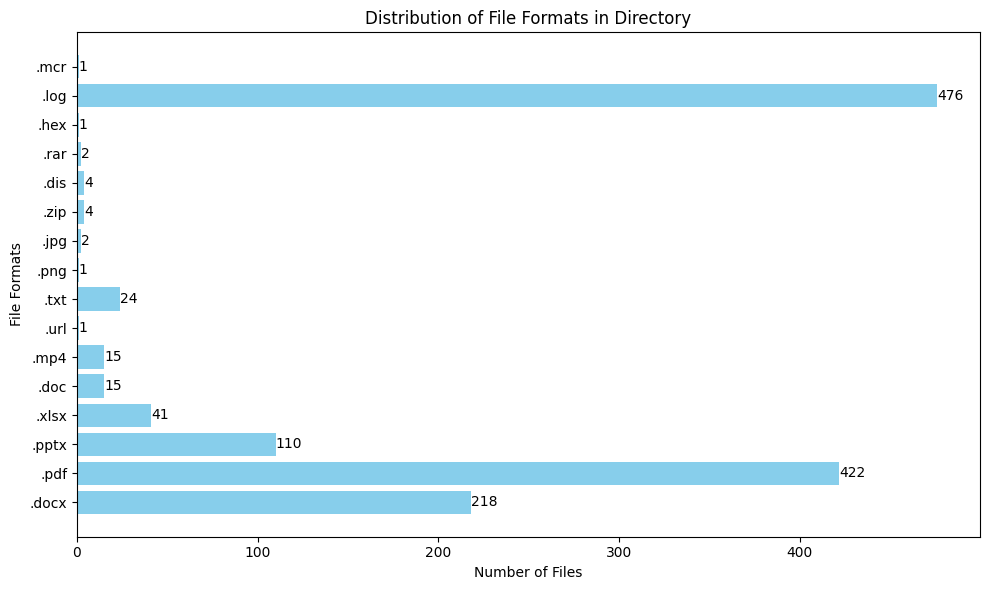

In [11]:
# Visualize the file formats results
plot_file_formats(formats_count)

## Show Repeated File Names

In [12]:
show_repeated_names(names_count)

Repeated file names (without extensions):

1. DECLARACION_DE_CONFORMIDAD_CE_CAMPANAS:
   - DECLARACION_DE_CONFORMIDAD_CE_CAMPANAS.docx
   - DECLARACION_DE_CONFORMIDAD_CE_CAMPANAS.pdf

2. DECLARATION_DE_CONFORMITE_CE_HOTTE:
   - DECLARATION_DE_CONFORMITE_CE_HOTTE.docx
   - DECLARATION_DE_CONFORMITE_CE_HOTTE.pdf

3. DECLARATION_OF_CONFORMITY_CE_HOODS:
   - DECLARATION_OF_CONFORMITY_CE_HOODS.docx
   - DECLARATION_OF_CONFORMITY_CE_HOODS.pdf

4. DECLARACION_DE_CONFORMIDAD_CE_FERMENTADORA:
   - DECLARACION_DE_CONFORMIDAD_CE_FERMENTADORA.docx
   - DECLARACION_DE_CONFORMIDAD_CE_FERMENTADORA.pdf

5. DECLARATION_DE_CONFORMITE_CE_ETUVES:
   - DECLARATION_DE_CONFORMITE_CE_ETUVES.docx
   - DECLARATION_DE_CONFORMITE_CE_ETUVES.pdf

6. DECLARATION_OF_CONFORMITY_CE_PROOFERS:
   - DECLARATION_OF_CONFORMITY_CE_PROOFERS.docx
   - DECLARATION_OF_CONFORMITY_CE_PROOFERS.pdf

7. DECLARACION_DE_CONFORMIDAD_CE_ENVASADORAS:
   - DECLARACION_DE_CONFORMIDAD_CE_ENVASADORAS.docx
   - DECLARACION_DE_CONFORMIDAD_CE_EN

# Clean Data
### Remove All files that are not valid
The valid format for files are txt, docx, xlsx, pptx, pdf. 

In [13]:
# Directory to analyze
directory_path = "C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST"
formats_count, names_count = analyze_directory(directory_path)

In [14]:
# Remove unsupported file formats
clean_files(directory_path)

# Convert DOC files to PDF
parse_doc_to_pdf(directory_path)

Deleted: C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST\Documentació Centro de Descargas\FICHAS TÉCNICAS\RENDIMIENTO PANADERIA BOLLERIA.xlsx
Deleted: C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST\Documentació Centro de Descargas\FICHAS TÉCNICAS\ACCESORIOS\Campana de condensación\OLD\Ficha Técnica Campana de Condensación.xlsx
Deleted: C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST\Documentació Centro de Descargas\FICHAS TÉCNICAS\ACCESORIOS\Campana de condensación frontal\Ficha Técnica Campana de Condensación Frontal.xlsx
Deleted: C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST\Documentació Centro de Descargas\FICHAS TÉCNICAS\ACCESORIOS\Campana de condensación y olores\Ficha Técnica Campanas de condensación y olores con filtro.xlsx
Deleted: C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST\Documentació Centro de Descargas\FICHAS TÉCNICAS\ACCESORIOS\Fermentadoras\FICHA TECNICA Fermentadoras.xlsx
Deleted: C:/Users/PLLOBET.DISTFORM/Desktop

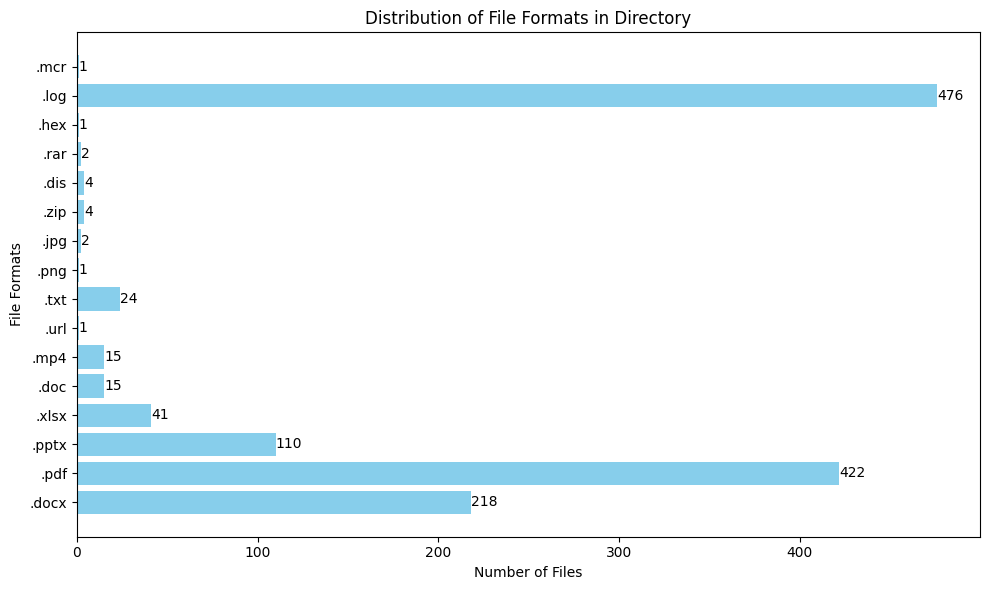

In [15]:
# Visualize the file formats results
plot_file_formats(formats_count)

### Remove Duplicated files

In [16]:
delete_duplicate_files(directory_path)

Deleted: C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST\Documentació Centro de Descargas\CE\ACCESORIOS\CAMPANAS\DECLARACION_DE_CONFORMIDAD_CE_CAMPANAS.docx
Deleted: C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST\Documentació Centro de Descargas\CE\ACCESORIOS\CAMPANAS\DECLARATION_DE_CONFORMITE_CE_HOTTE.docx
Deleted: C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST\Documentació Centro de Descargas\CE\ACCESORIOS\CAMPANAS\DECLARATION_OF_CONFORMITY_CE_HOODS.docx
Deleted: C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST\Documentació Centro de Descargas\CE\ACCESORIOS\FERMENTADORA\DECLARACION_DE_CONFORMIDAD_CE_FERMENTADORA.docx
Deleted: C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST\Documentació Centro de Descargas\CE\ACCESORIOS\FERMENTADORA\DECLARATION_DE_CONFORMITE_CE_ETUVES.docx
Deleted: C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST\Documentació Centro de Descargas\CE\ACCESORIOS\FERMENTADORA\DECLARATION_OF_CONFORMITY_CE_PROOFERS

No repeated file names found.


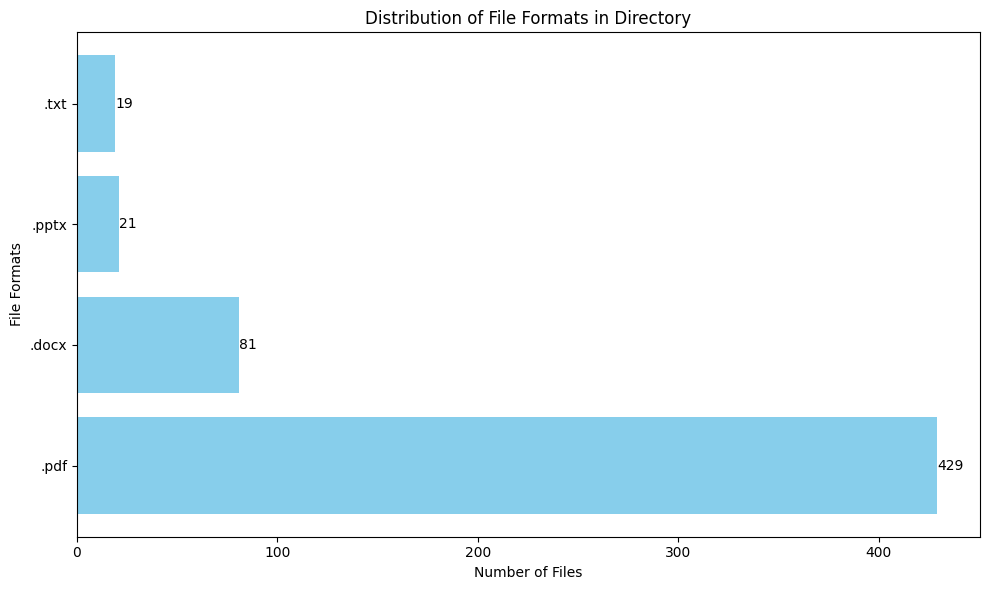

In [17]:
formats_count, names_count = analyze_directory(directory_path)

# Visualize changes
show_repeated_names(names_count)
plot_file_formats(formats_count)

## Move documents in root directory

In [18]:
# Refactor files in Documentació Centro de Descargas
move_files_and_clean_empty_dirs(directory_path + "/Documentació Centro de Descargas/DESPIECE + LISTADO DE CAMBIOS")
move_files_and_clean_empty_dirs(directory_path + "/Documentació Centro de Descargas/FICHAS TÉCNICAS")
move_files_and_clean_empty_dirs(directory_path + "/Documentació Centro de Descargas/MANUALES DE PRODUCTO")
move_files_and_clean_empty_dirs(directory_path + "/Documentació Centro de Descargas/MANUALES SAT")

Moved: C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST/Documentació Centro de Descargas/DESPIECE + LISTADO DE CAMBIOS\ACCESORIOS\CAMPANAS\DESPIECE_Y_LISTADO DE RECAMBIOS_CAMPANAS.pdf to C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST/Documentació Centro de Descargas/DESPIECE + LISTADO DE CAMBIOS
Moved: C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST/Documentació Centro de Descargas/DESPIECE + LISTADO DE CAMBIOS\ACCESORIOS\CAMPANAS\DESPIECE_Y_LISTADO DE RECAMBIOS_CAMPANAS_TARIFA_2023.docx to C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST/Documentació Centro de Descargas/DESPIECE + LISTADO DE CAMBIOS
Moved: C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST/Documentació Centro de Descargas/DESPIECE + LISTADO DE CAMBIOS\ACCESORIOS\FERMENTADORA\DESPIECE_Y_LISTADO_DE_RECAMBIOS_FERMENTADORA.pdf to C:/Users/PLLOBET.DISTFORM/Desktop/UdL/TFM/TRAIN_DATA/TEST/Documentació Centro de Descargas/DESPIECE + LISTADO DE CAMBIOS
Moved: C:/Users/PLLOBET.DIST

In [19]:

def count_files_in_directory(directory):
    if not os.path.exists(directory):
        raise ValueError(f"The directory {directory} does not exist.")
    file_count = 0
    for root, dirs, files in os.walk(directory):
        file_count += len(files)

    return file_count

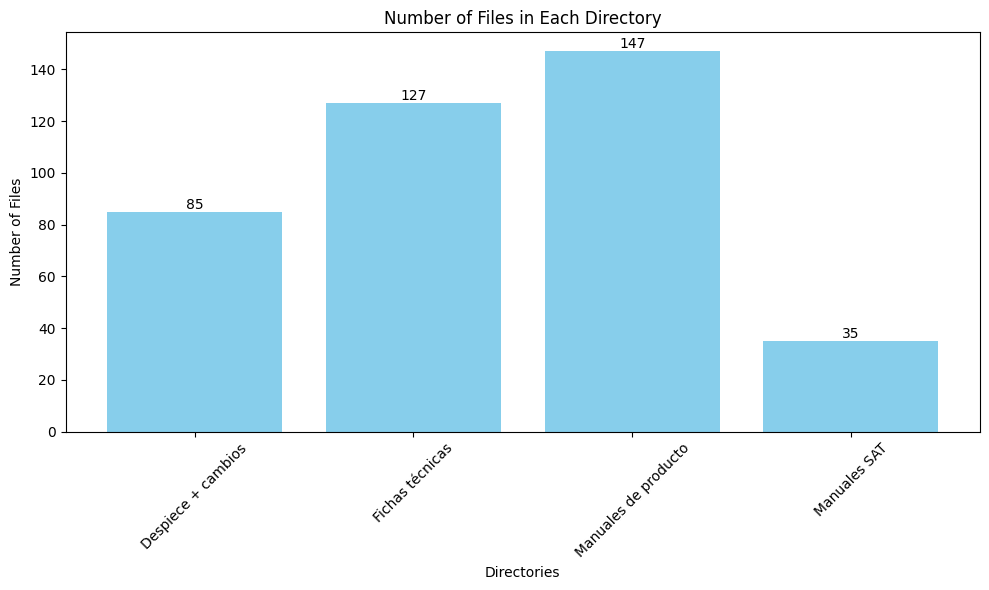

In [20]:
directories = ['Despiece + cambios', 'Fichas técnicas', 'Manuales de producto', 'Manuales SAT']
file_counts = [count_files_in_directory(directory_path + "/Documentació Centro de Descargas/DESPIECE + LISTADO DE CAMBIOS"), 
                count_files_in_directory(directory_path + "/Documentació Centro de Descargas/FICHAS TÉCNICAS"), 
                count_files_in_directory(directory_path + "/Documentació Centro de Descargas/MANUALES DE PRODUCTO"), 
                count_files_in_directory(directory_path + "/Documentació Centro de Descargas/MANUALES SAT")]

plot_directories_and_file_counts(directories, file_counts)